In [602]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import copy
import tsplib95 as tlib

from networkx.algorithms import community

warnings.simplefilter('ignore')

In [603]:
"""
    Metoda care citeste un graf dintr-un fisier de tip tsp
    @params: filename - path catre un fisier tsp 
    @return: Graph - un obiect de tip Graph
"""
def readData(filename):
   graph = nx.Graph()
   with open(filename) as f:
    n = int(f.readline().split()[0])
    graph.add_nodes_from(list(range(1, n + 1)))

    for i in range(1, n + 1):
      line = f.readline()
      for weight, j in zip(line.split(","), range(1, n + 1)):
        if int(weight) > 0 and int(weight) < 0x3f3f3f3f:
          graph.add_edge(i, j, weight = int(weight))

    extremities = []
    extremities.append(int(f.readline().split()[0]))
    extremities.append(int(f.readline().split()[0]))

    return [graph, extremities]

In [604]:
def readSolution(filename):
    lista = []
    with open(filename) as f:
        for _ in range(5):
            f.readline()

        for line in f:
            value = int(line.split()[0])
            if value == -1:
                break
            lista.append(value)
    
    return lista

In [605]:
"""
    Metoda care afiseaza impartirea in comunitati a algoritmului impreuna cu cea true, daca aceasta este data
    @params: G - reteaua
             predictedCommunities - impartirea in comunitati prezisa
             targetCommunities - adevarata impartirea in comunitati
             node_size - marimea nodurilor din desen 
"""
def plotPredictedTargetNetworkAndFitness(G, fitness, predictedCommunities, fitnesses, generations, targetCommunities = None, node_size = 50):
    np.random.seed(42)


    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)

    fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

    nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = predictedCommunities, ax = axis[0])
    nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[0]) # alpha = edge transparancy
    nx.draw_networkx_labels(G, pos, ax = axis[0]) # alpha = edge transparancy
    axis[0].set_title("Predicted \n number of communities = " + str(len(np.unique(predictedCommunities))) + "\n fitness = " + str(fitness))

    if targetCommunities != None:
        nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = targetCommunities, ax = axis[1])
        nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[1]) # alpha = edge transparancy
        nx.draw_networkx_labels(G, pos, ax = axis[1]) # alpha = edge transparancy
        axis[1].set_title("target")
    
    axis[2].plot(range(1, generations + 1), fitnesses, '-r')

In [606]:
def plotTSP(G, chromosomes, fitnesses, noGen, node_size = 50):
    np.random.seed(42)

    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    
    for chr in chromosomes:
        repr = chr.representation[:]
        for x, y in zip(repr, repr[1:]):
            H.add_edge(x, y, color = 'r')
    
    for edge in G.edges:
        if not H.has_edge(edge[0], edge[1]):
            H.add_edge(edge[0], edge[1], color = 'b')

    pos = nx.spring_layout(H)
    _, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

    nx.draw_networkx_nodes(H, pos, node_size = node_size, cmap = plt.cm.RdYlBu, ax = axis[0])

    edges = H.edges()
    colors = [H[x][y]['color'] for x, y in edges]

    nx.draw_networkx_edges(H, pos, alpha = 0.7, ax = axis[0], edgelist=edges, edge_color=colors)
    nx.draw_networkx_labels(H, pos, ax = axis[0]) # alpha = edge transparancy

    axis[1].set_title("Predicted = " + str(chromosomes[0].fitness))
    axis[1].plot(list(range(noGen)), fitnesses, '-r')

In [607]:
"""
    Metoda care returneaza un element ales aleator din lista data
    @params: list - o lista
    @return: un element din lista
"""
def uniformChoiceList(list):
    return np.random.choice(list)

In [608]:
a = [1, 2, 3, 4]
print(a[-1])

4


In [609]:
class Chromosome:

    def __init__(self, graph = None, extremities = None, representation = None):
        self.__representation = []
        if graph != None and extremities != None:
            self.__possibleValues = list(graph.nodes())
            self.__representation = Chromosome.__initialiaze(graph, extremities)
        elif representation != None:
            self.__representation = representation  
            
        self.__fitness = None 

    @classmethod
    def __initialiaze(cls, graph, extremities):
        representation = [extremities[0]]

        while representation[-1] != extremities[1]:
           possible = [node for node in graph.neighbors(representation[-1]) if node not in representation]
           representation.append(np.random.choice(possible))
        
        return representation

    @property
    def representation(self):
        return self.__representation
    
    @property
    def fitness(self):
        return self.__fitness
    
    @representation.setter
    def representation(self, representation = []):
        self.__representation = representation 
    
    @fitness.setter
    def fitness(self, fitness = None):
        self.__fitness = fitness
    
    def representationEdges(self):
        edges = []

        for i in range(len(self.__representation) - 1):
            edges.append([self.__representation[i], self.__representation[i + 1]])
        
        return edges

    """
        Metoda care produce o incrucisare intre doi cromozomi
        @params: chr - un cromozom
        @return: un cromozom reprezentand rezultatul incrucisarii celor dou
    """
    def crossover(self, chr): 

        intersections = [i for i in range(min(len(self.__representation), len(chr.representation))) if self.__representation[i] == chr.representation[i]]
        point = np.random.choice(intersections)

        newRepresenation1 = self.__representation[:(point + 1)]
        newRepresenation2 = chr.representation[:(point + 1)]

        for i in range(point + 1, len(chr.representation)):
            newRepresenation1.append(chr.representation[i])
        for i in range(point + 1, len(self.__representation)):
            newRepresenation2.append(self.__representation[i])
        
        offspring = Chromosome()        
        offspring.representation = newRepresenation1 if np.random.random() <= 0.5 else newRepresenation2 
        offspring.__possibleValues = self.__possibleValues
        return offspring
    
    def __inversionMutation(self):
        pos1 = np.random.randint(0, len(self.__representation) - 2)
        pos2 = np.random.randint(pos1 + 1, len(self.__representation))
        middle = list(reversed(self.__representation[(pos1 + 1):(pos2 + 1)]))

        for i in range(pos1 + 1, pos2 + 1):
            self.__representation[i] = middle[i - pos1 - 1]

    """
        Metoda care produce o mutatie la nivelul cromozomului
        @params: network - reteaua pentru care se identifica comunitatile
        @return: -
    """
    def mutation(self, graph):
        pass
        #self.__inversionMutation()
        #self.__rgibnnm(graph)
    
    def __rgibnnm(self, graph):
        pos = np.random.randint(0, len(self.__representation))
        nearestNeighbor = Chromosome.__nearestNeighbor(self.__representation[pos], graph)
        nghPosition = list(self.__representation).index(nearestNeighbor)

        swapPos = np.random.choice(list(range(max(0, nghPosition - 5), min(len(self.__representation), nghPosition + 6))))
        self.__representation[pos], self.__representation[swapPos] = self.__representation[swapPos], self.__representation[pos]

In [610]:
class PathFitness:

    def __init__(self, graph):
        self.__graph = graph 

    def __call__(self, representation):
        result = 0
        for i in range(len(representation) - 1):
            result += self.__graph[representation[i]][representation[i + 1]]["weight"]
        
        return result

In [611]:
class GA:
    def __init__(self, params, problParams):
        self.__params = params
        self.__problParams = problParams
        self.__population = []

        self.__initialization()
        self.__evaluation()
        self.__bestChrs = [self.__population[0]]
    
    def __initialization(self):
        for _ in range(self.__params['popSize']):
            self.__population.append(Chromosome(graph = self.__problParams['graph'], extremities = self.__problParams['extremities']) )

    @property
    def population(self):
        return self.__population
    
    def __evaluation(self):
        for chr in self.__population:
            if chr.fitness == None:
                chr.fitness = self.__problParams['fitness'](chr.representation)
        
        self.__probabilities = self.__populationProbabilities(self.__population) 
    
    def bestChromosomes(self):
        bestFitness = 0x3f3f3f3f
        bests = [self.__population[0]]
        for chr in self.__population:
            if chr.fitness < bestFitness:
                bests = [chr]
                bestFitness = chr.fitness
            elif chr.fitness == bestFitness:
                bests.append(chr)
        return bests

    def worstChromosome(self):
        worst = self.__population[0]
        for chr in self.__population:
            if chr.fitness > worst.fitness:
                worst = chr
        return worst 
    
    def __selection(self):
        """
        best = self.__population[np.random.randint(0, self.__params['popSize'])]
        
        for _ in range(self.__params['k'] - 1):
            position = np.random.randint(0, self.__params['popSize'])
            if best.fitness < self.__population[position].fitness:
                best = self.__population[position] 

        return best
        """

        position1 = np.random.randint(0, self.__params['popSize'])
        position2 = np.random.randint(0, self.__params['popSize'])
        if self.__population[position1].fitness < self.__population[position2].fitness:
            return self.__population[position1]
        return self.__population[position2]
        
    def __sampleChromosomes(self, population, number, probabilities):
        return list(np.random.choice(population, size = number, p = probabilities, replace = False))
    
    def __populationProbabilities(self, population):
        fitnessSum = sum([1 / chr.fitness for chr in population])
        return [(1 / chr.fitness) / fitnessSum for chr in population]
    
    def __oneRoulleteFractionGenerator(self):
        newPop = self.__sampleChromosomes(self.__population, int(self.__params['pc'] * self.__params['popSize']), self.__probabilities)
        probabilities = self.__populationProbabilities(newPop) 

        crossoverPop = []
        for _ in range(self.__params['popSize'] - len(newPop)):
            chrs = self.__sampleChromosomes(newPop, 2, probabilities)
            crossoverPop.append(chrs[0].crossover(chrs[1]))
        newPop.extend(crossoverPop)
        
        for i in range(self.__params['popSize']):
            if np.random.random() <= self.__params['pm']:
                newPop[i].mutation(self.__problParams['graph'])
        
        self.__population = newPop
        self.__evaluation()

    def __oneGeneration(self):
        newPop = []
        for _  in range(self.__params['popSize']):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            offspring.mutation(self.__problParams['graph'])
            newPop.append(offspring)

        self.__population = newPop
        self.__evaluation()

    def __oneGenerationElitism(self):
        newPop = self.bestChromosomes()
        for _  in range(self.__params['popSize'] - len(newPop)):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            newPop.append(offspring)

        for i in range(self.__params['popSize']):
            if np.random.random() <= self.__params['pm']:
                newPop[i].mutation(self.__problParams['graph'])

        self.__population = newPop
        self.__evaluation()
    
    def __oneGenerationSteadyState(self):
        for _ in range(self.__params['popSize']):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            offspring.mutation(self.__problParams['graph'])
            offspring.fitness = self.__problParams['fitness'](offspring.representation)
            worst = self.worstChromosome()
            if offspring.fitness < worst.fitness:
                worst = offspring

    def solve(self):
        fitnesses = []
        for i in range(self.__params['noGen']):
            self.__oneRoulleteFractionGenerator()
            bestChrs = self.bestChromosomes()

            if self.__bestChrs[0].fitness > bestChrs[0].fitness:
                self.__bestChrs = bestChrs[:]
            elif self.__bestChrs[0] == bestChrs[0].fitness:
                self.__bestChrs.extend(bestChrs)

            fitnesses.append(sum([chr.fitness for chr in self.__population]) / self.__params['popSize'])
        
        return [list(set(self.__bestChrs)), fitnesses]

In [612]:
def createGraph(nodes, outputfile, p = 0.5, minWeight = 1, maxWeight = 20, infinity = 0x3f3f3f3f):
    with open(outputfile, 'w') as file:
        file.write(str(nodes) + "\n")
        for i in range(nodes):
            row = ""
            for j in range(nodes):
                if i == j:
                    row += str(0) + ","
                elif np.random.random() <= p:
                    row += str(np.random.randint(minWeight, maxWeight + 1)) + ","
                else:
                    row += str(infinity) + ","
            row = row[:-1] + "\n"
            file.write(row)
        start = np.random.randint(1, nodes + 1)
        end = start
        while end == start:
            end = np.random.randint(1, nodes + 1)

        file.write(str(start) + "\n")
        file.write(str(end) + "\n")

#createGraph(5, os.path.join(os.getcwd(), 'data_sp', 'unu.txt'))
#createGraph(7, os.path.join(os.getcwd(), 'data_sp', 'doi.txt'))
#createGraph(10, os.path.join(os.getcwd(), 'data_sp', 'trei.txt'))
#createGraph(9, os.path.join(os.getcwd(), 'data_sp', 'patru.txt'), minWeight=10, maxWeight=100)
#createGraph(11, os.path.join(os.getcwd(), 'data_sp', 'cinci.txt'))
#createGraph(15, os.path.join(os.getcwd(), 'data_sp', 'sase.txt'), minWeight=25, maxWeight=500)
#createGraph(30, os.path.join(os.getcwd(), 'data_sp', 'sapte.txt'), p = 0.4)
#createGraph(50, os.path.join(os.getcwd(), 'data_sp', 'opt.txt'), p = 0.2)
#createGraph(100, os.path.join(os.getcwd(), 'data_sp', 'noua.txt'), minWeight=10, maxWeight=50, p = 0.1)

In [613]:
paths = [os.path.join(os.getcwd(), 'data_sp', 'unu.txt'),
         os.path.join(os.getcwd(), 'data_sp', 'doi.txt'), os.path.join(os.getcwd(), 'data_sp', 'trei.txt'),
         os.path.join(os.getcwd(), 'data_sp', 'patru.txt'), os.path.join(os.getcwd(), 'data_sp', 'cinci.txt'),
         os.path.join(os.getcwd(), 'data_sp', 'sase.txt'), os.path.join(os.getcwd(), 'data_sp', 'sapte.txt'),
         os.path.join(os.getcwd(), 'data_sp', 'opt.txt'), os.path.join(os.getcwd(), 'data_sp', 'noua.txt')]
graphs = []
extremities = []

for path in paths:
    [gr, extr] = readData(path)
    graphs.append(gr)
    extremities.append(extr)

In [614]:
gaParams = {'popSize': 5, 'noGen': 100, 'k': 2, 'pc' : 0.95, 'pm': 0.1}


In [615]:
def solveAndPlot(graph, extremities):
    params = {'graph': graph, 'fitness': PathFitness(graph), 'extremities': extremities}
    ga = GA(gaParams, params)
    [chromosomes, fitnesses] = ga.solve()
    
    plotTSP(graph, chromosomes, fitnesses, gaParams['noGen'])

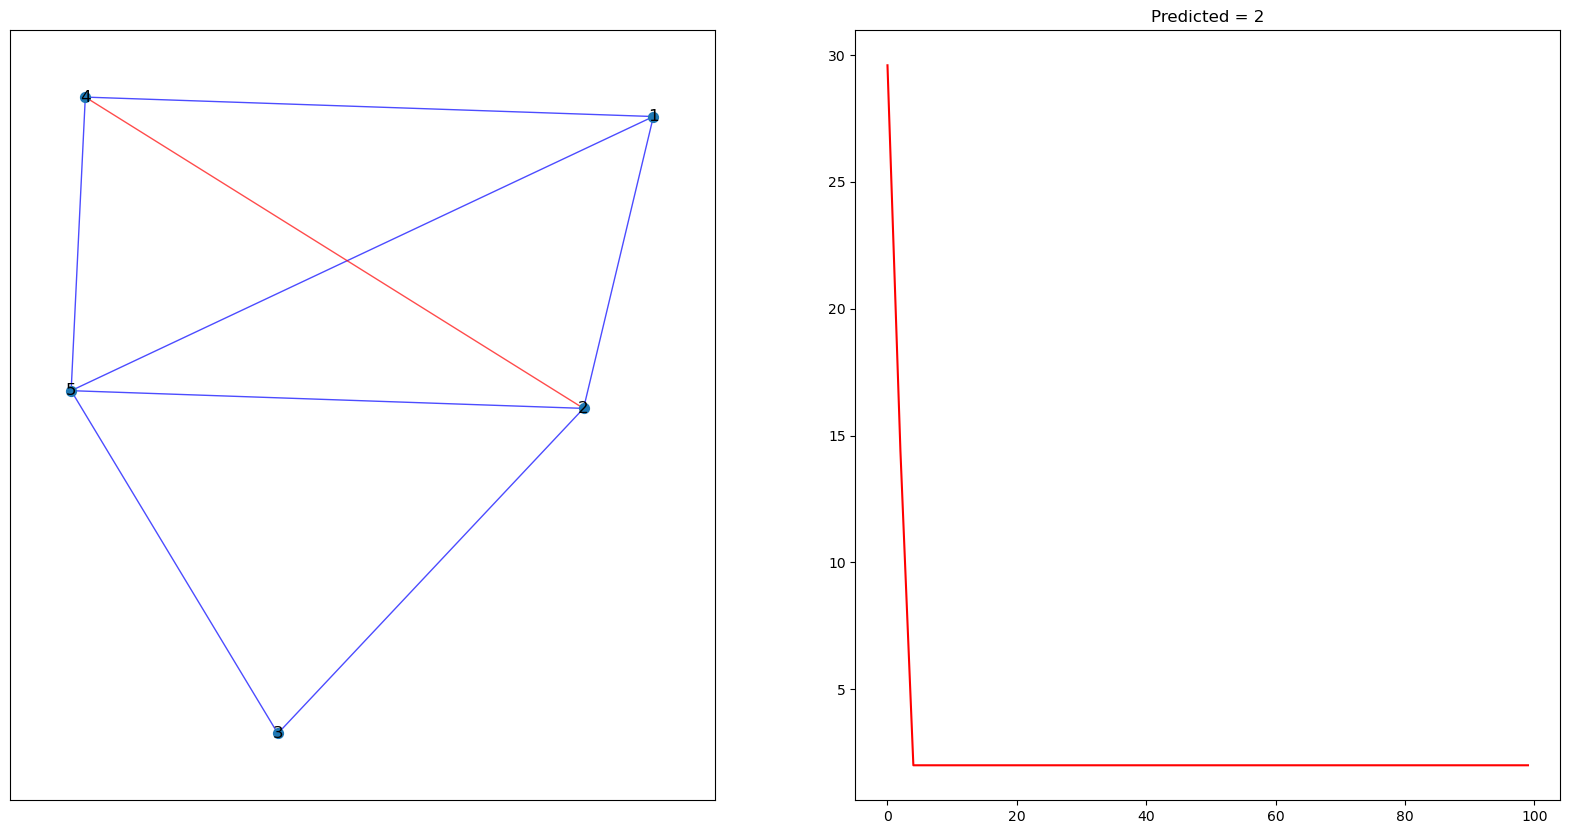

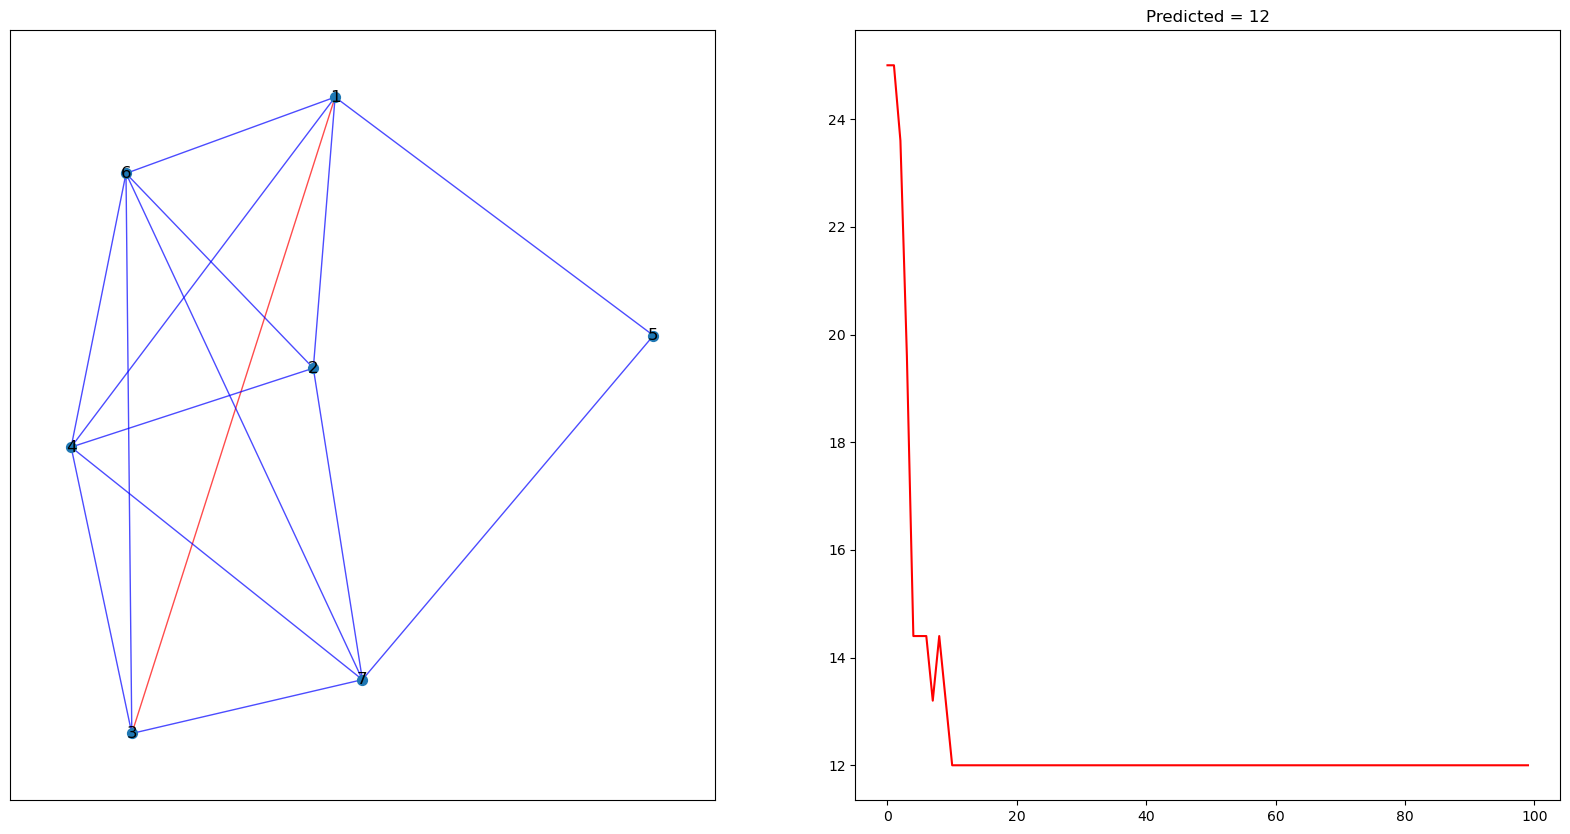

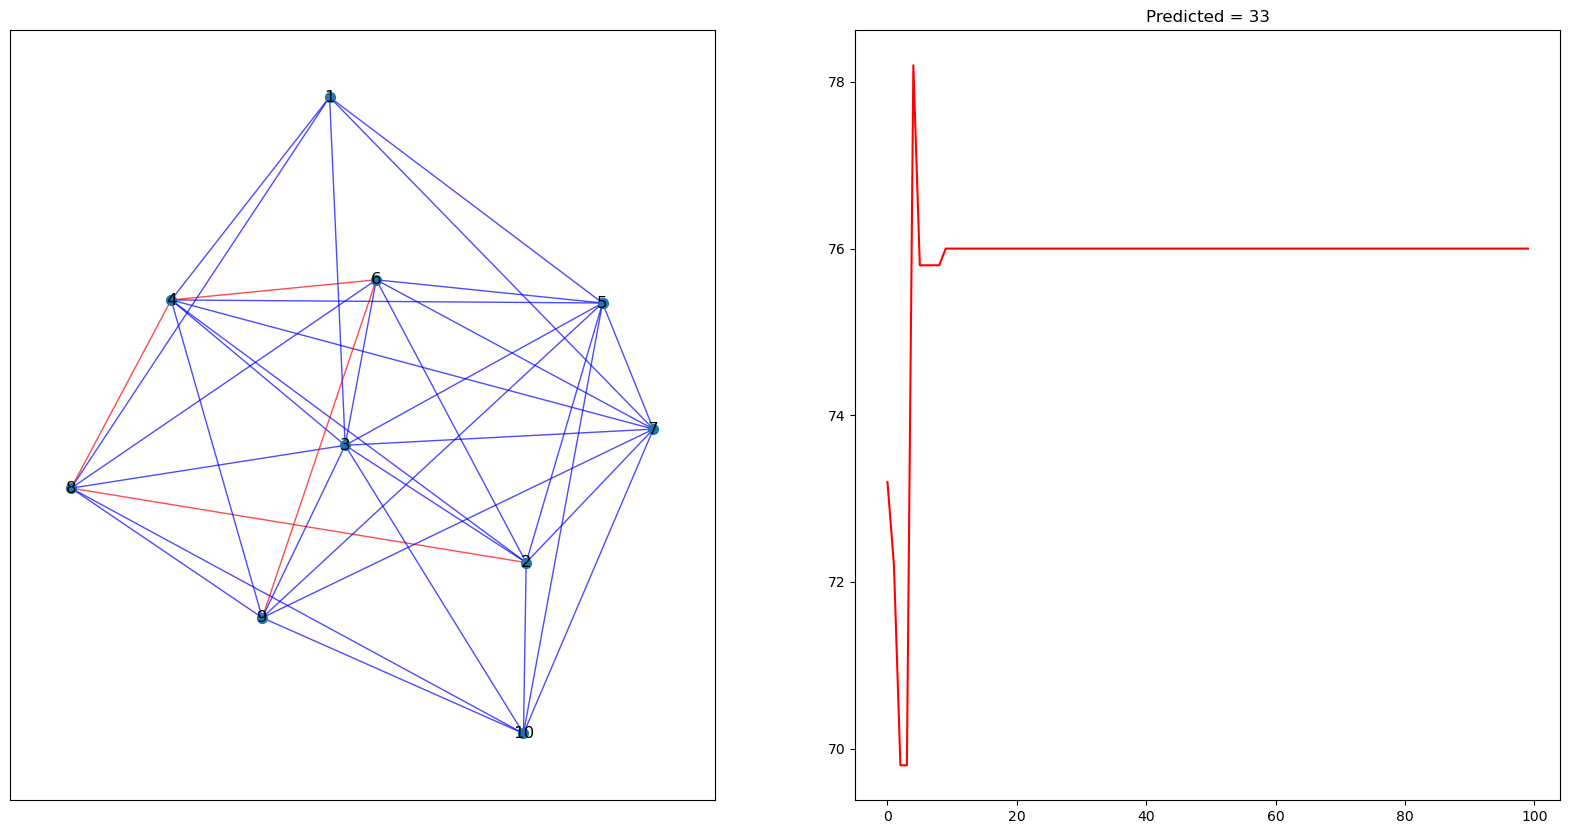

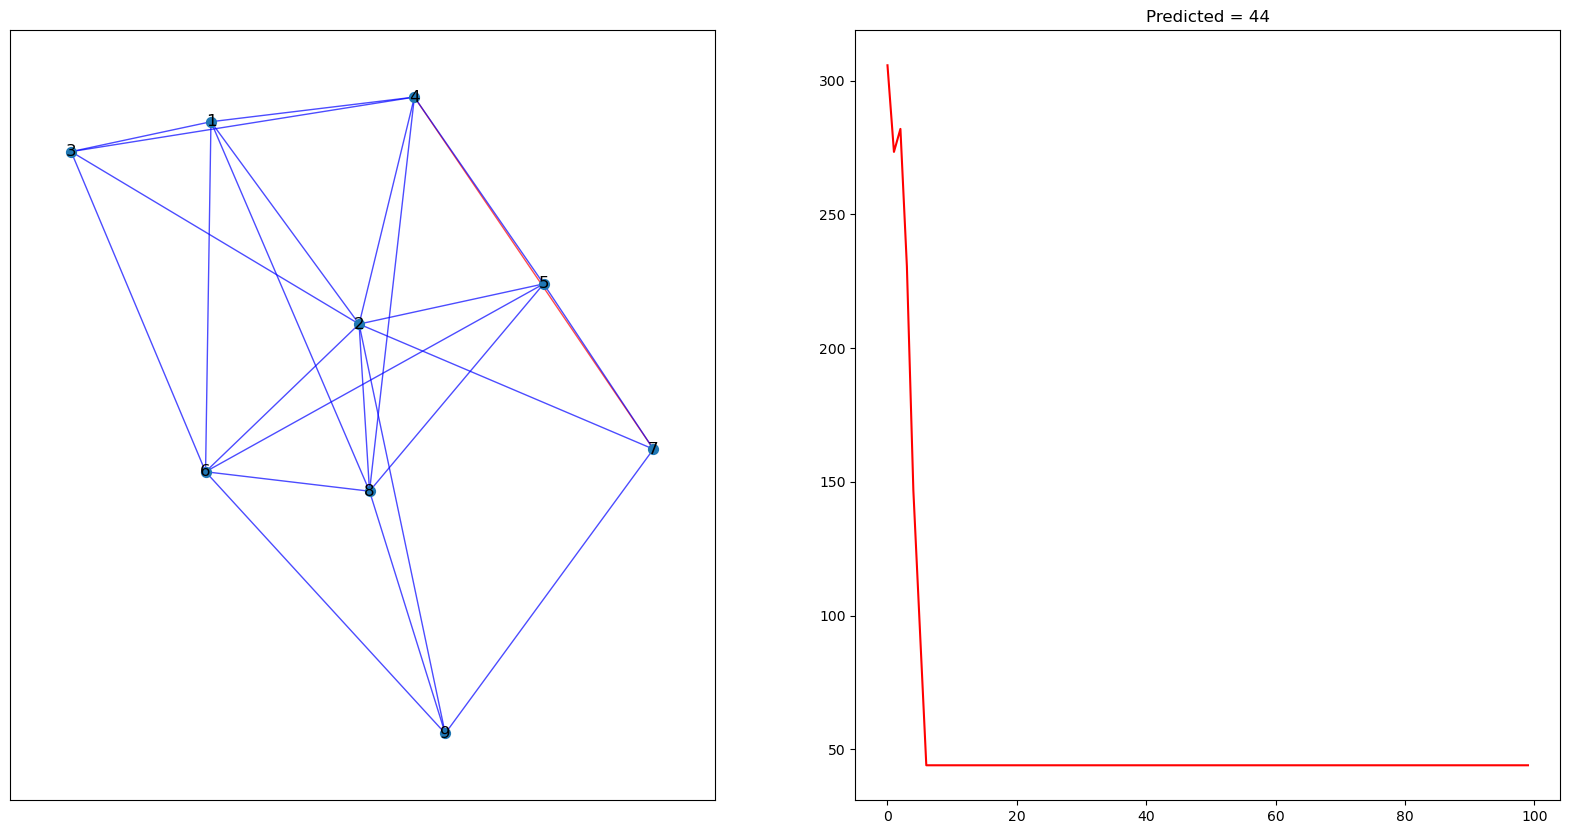

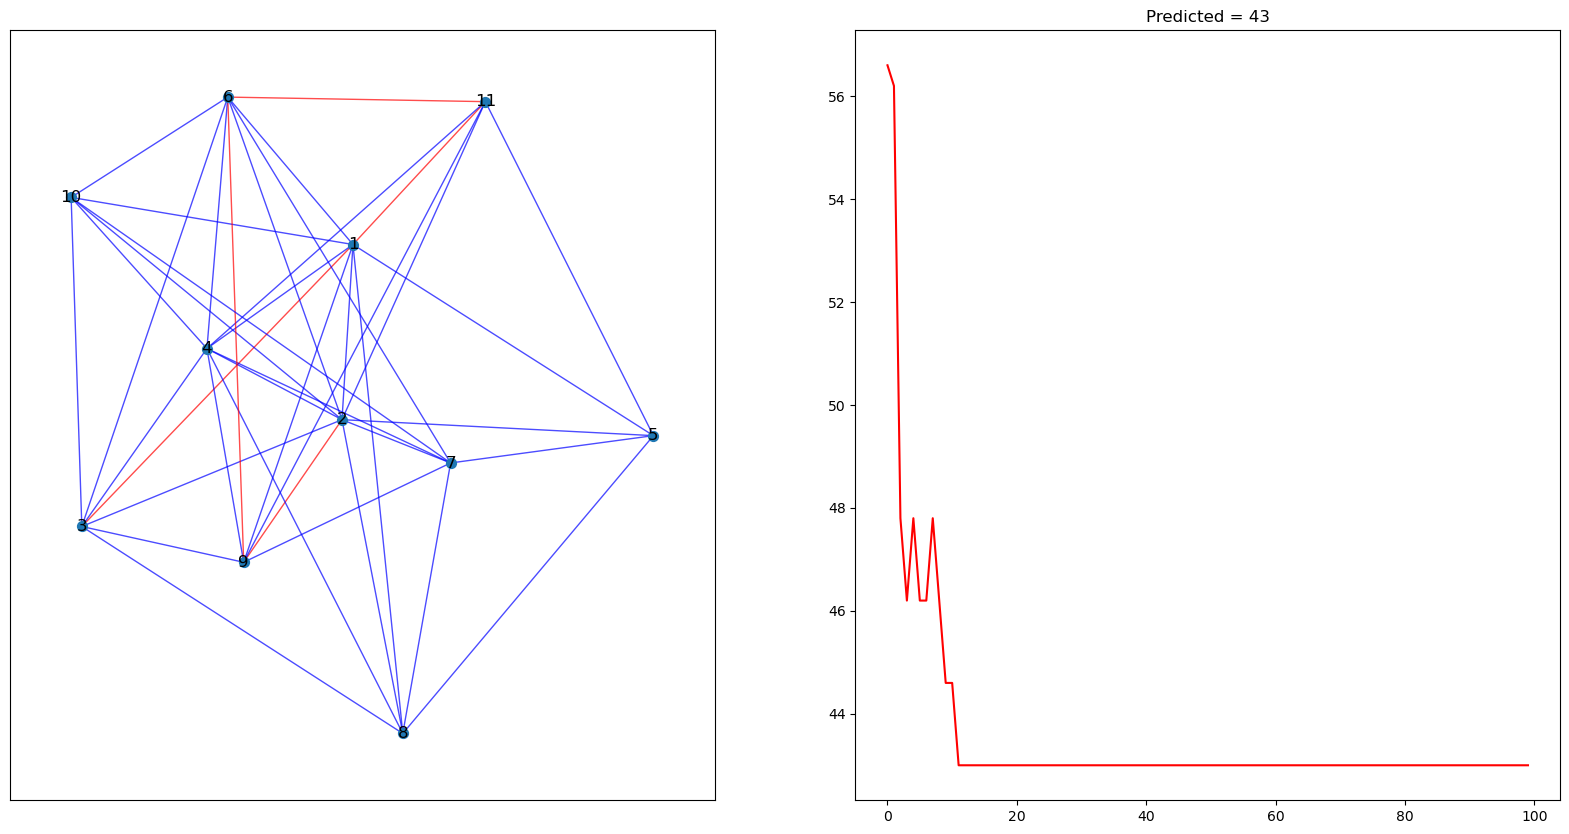

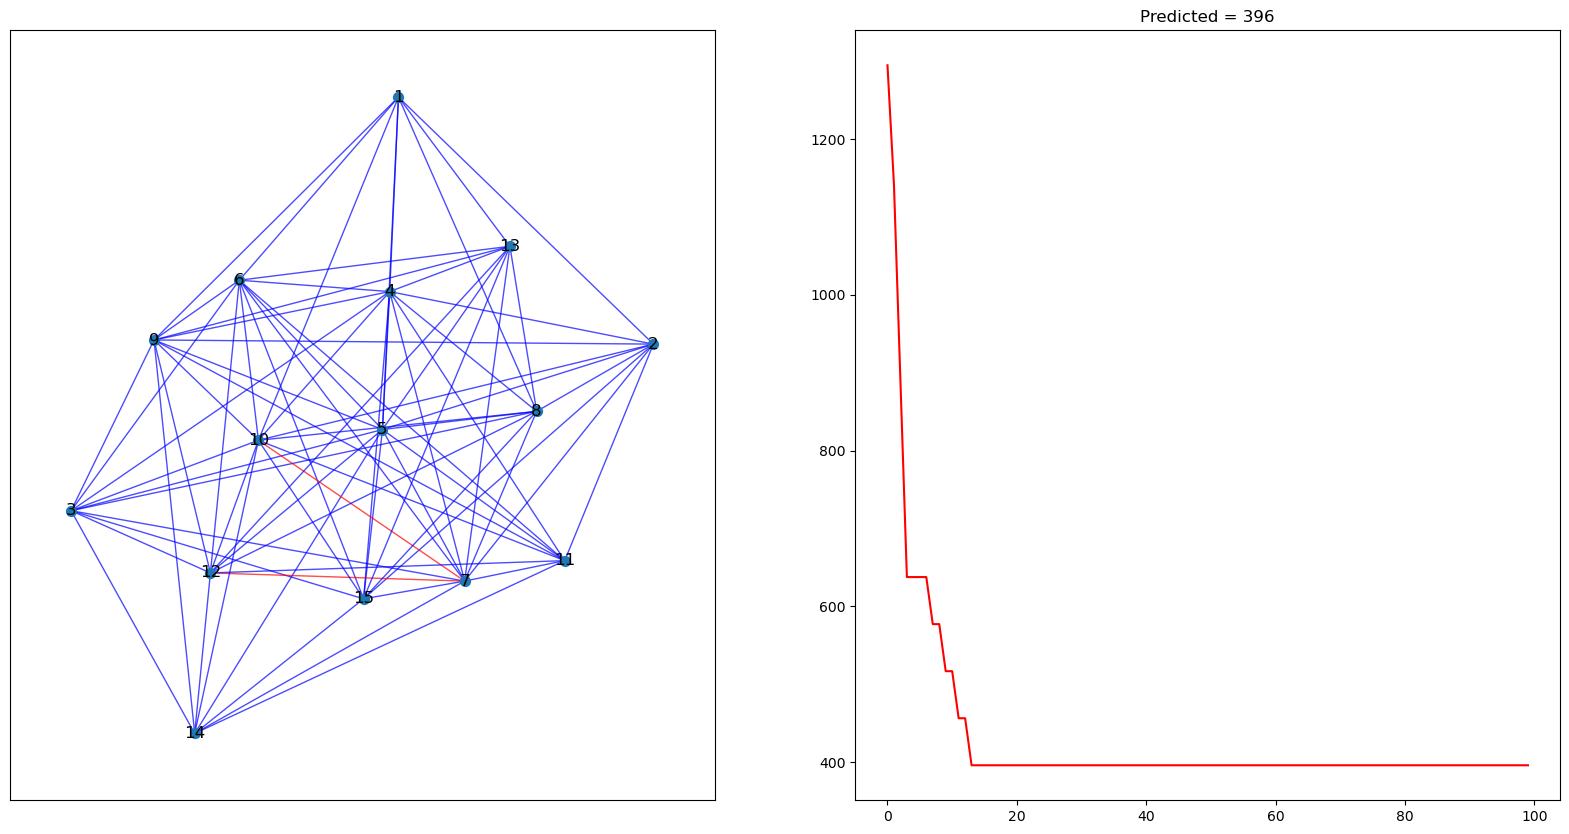

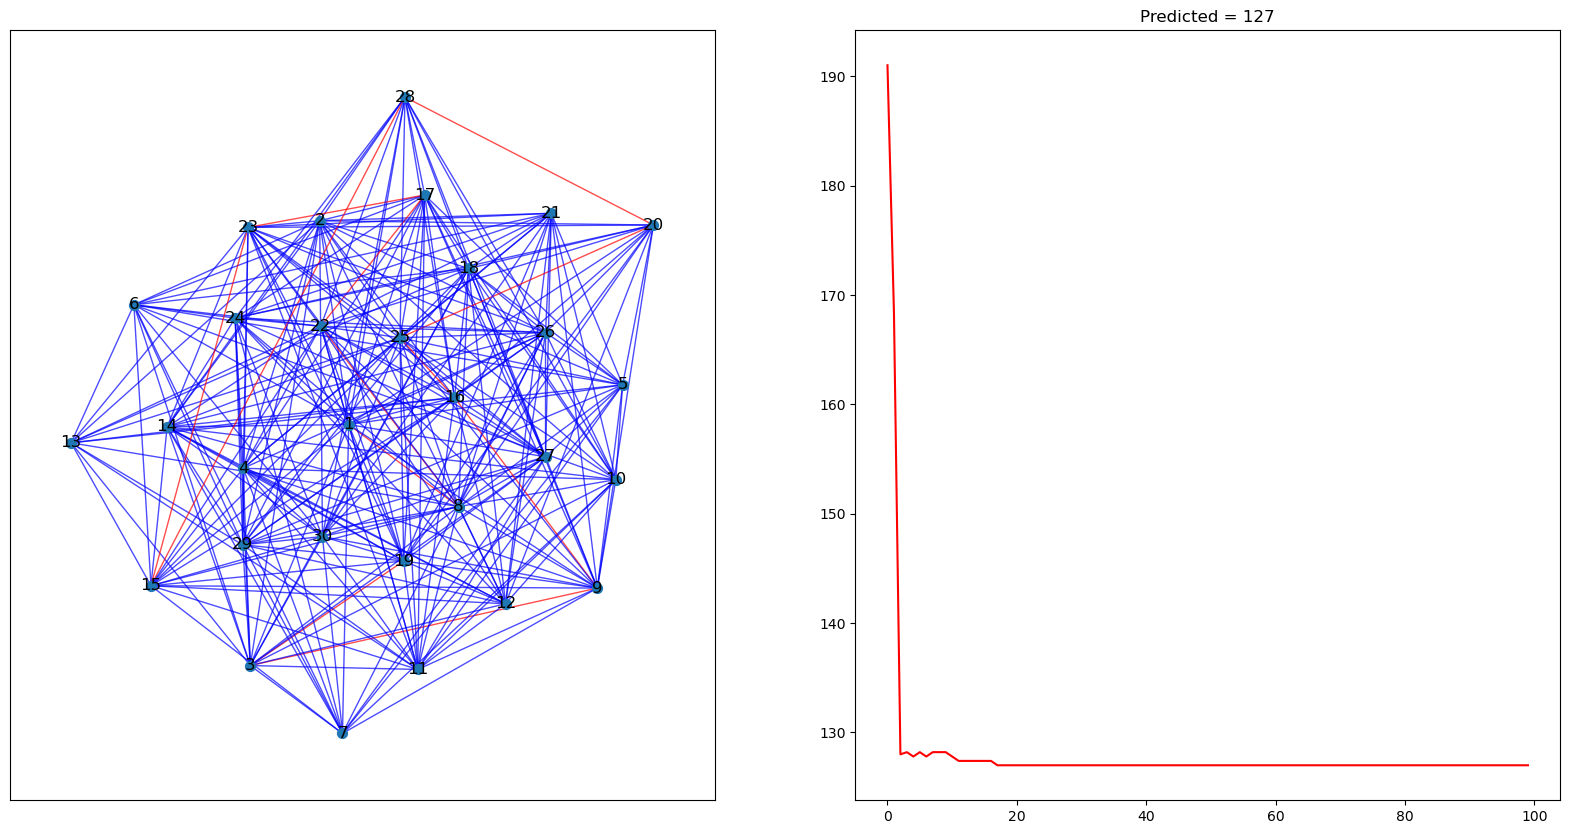

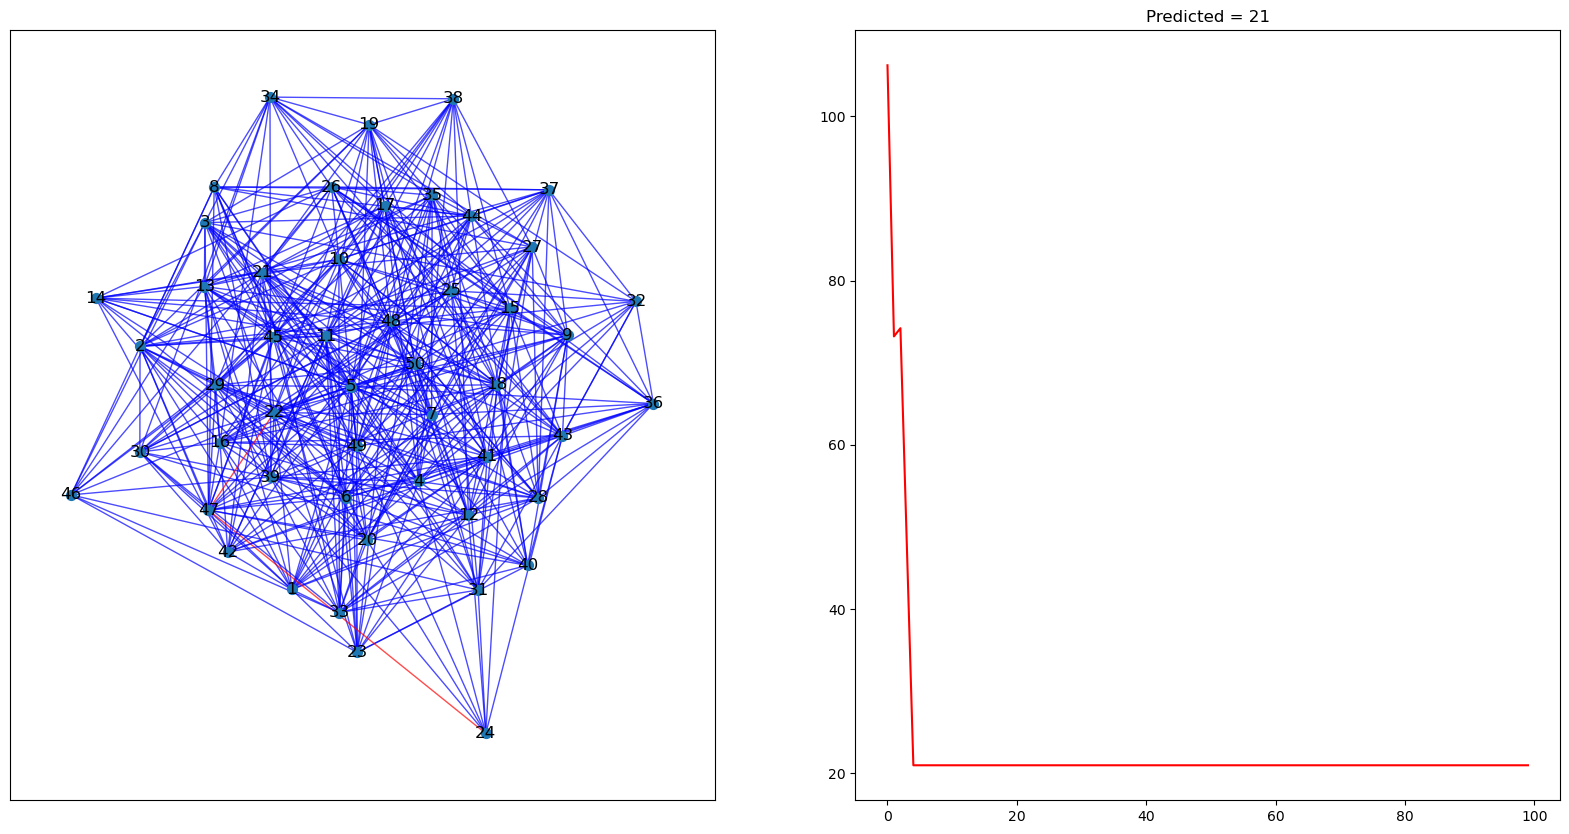

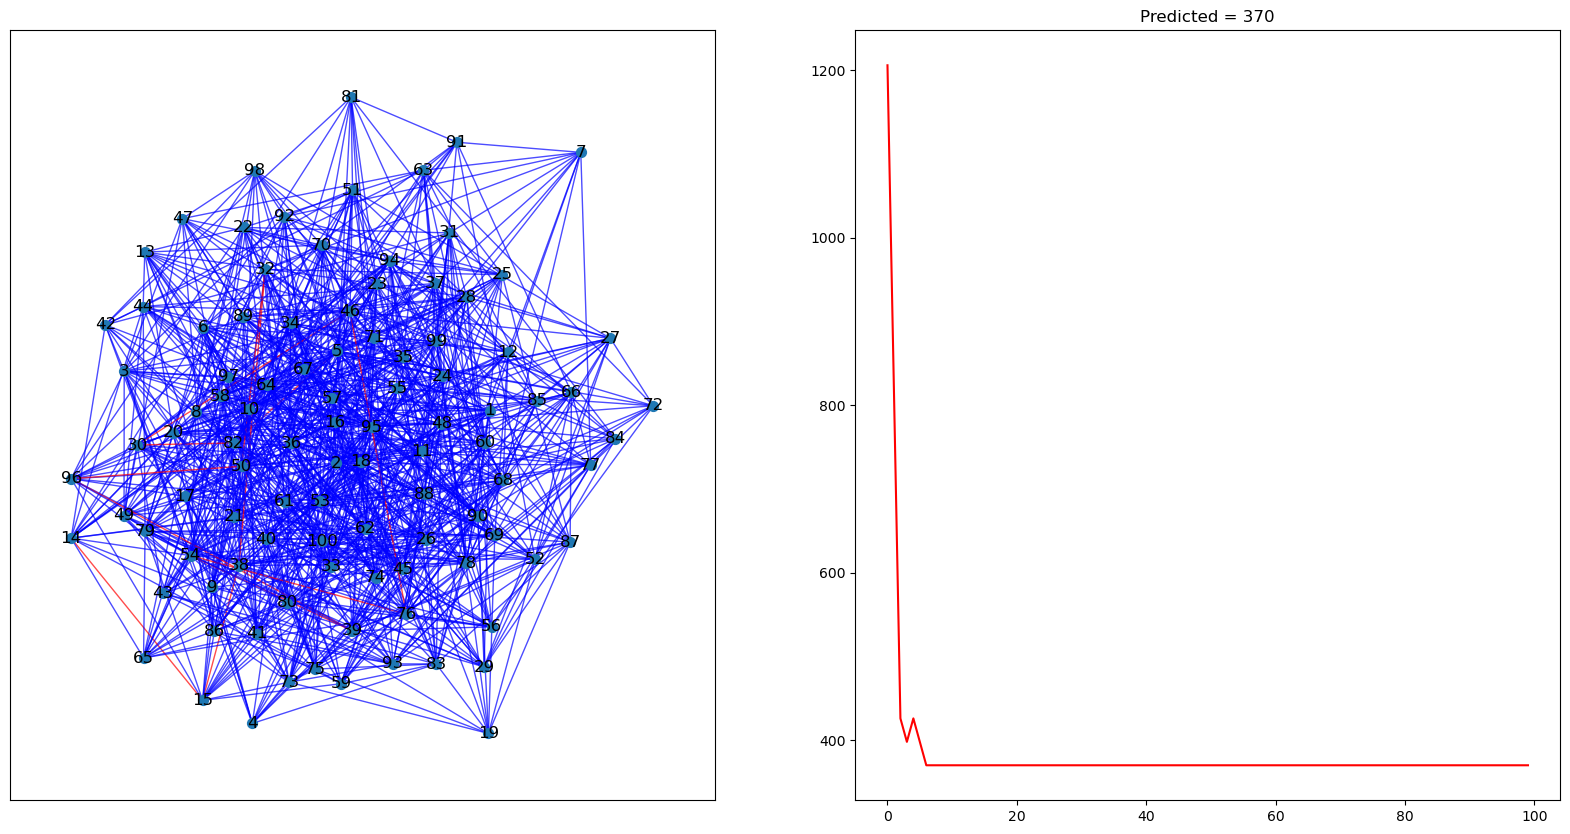

In [616]:
for graph, extrs in zip(graphs, extremities):
    solveAndPlot(graph, extrs)